# NLP (Natural Language Processing) with Python

This project basically consists of combining machine learning techniques with text, and using math and statistics to get that text in a format that the machine learning algorithms can understand!

In [1]:
import nltk

In [2]:
# nltk.download()

## Getting the Data

* Using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

* The file I am using contains a collection of more than 5 thousand SMS phone messages.

Using rstrip() plus a list comprehension to get a list of all the lines of text messages:

In [3]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print(len(messages))

5574


**A collection of texts is also sometimes called "corpus". Let's print the first ten messages and number them using *`enumerate`*:**

In [4]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

>Due to the spacing we can tell that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Numbers aren't part of the file, they are just from the **enumerate** call).

>Using these labeled ham and spam examples, Let's **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

>From the official SciKit Learn documentation, we can visualize our process:

**Instead of parsing TSV manually using Python, we can just take advantage of pandas!**

In [5]:
import pandas as pd 

**Using *'read_csv'* and make note of the *'sep'* argument, we can also specify the desired column names by passing in a list of *names*.**

In [6]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [7]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Using **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [8]:
messages.groupby('label').describe().transpose()

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

> As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering).


**Let's make a new column to detect how long the text messages are:**

In [9]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


# Data Visualization


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [11]:
sns.set_style('whitegrid')

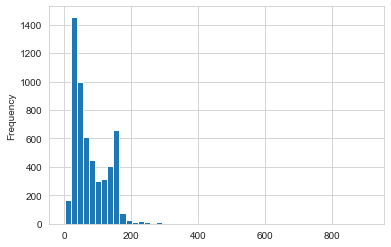

In [12]:
messages['length'].plot(bins=50, kind='hist') 

>Let's analyse why the x-axis goes all the way to 1000ish, this must mean that there is some really long message!

In [13]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

>910 characters, let's use masking to find this message:

In [14]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

**Let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026EC69E5FC8>,
      dtype=object)

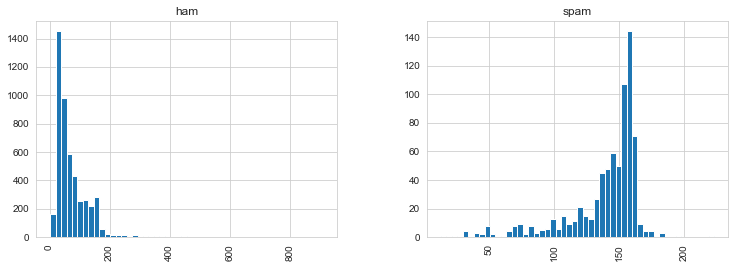

In [15]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

>Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters. 

**Now let's begin to process the data so we can eventually use it with SciKit Learn!**

# Text Pre-processing

* Our main issue with the data is that it is all in text format (strings). There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.


* We'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

* Writing a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. Using some of the basic ones here.

* Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

* First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [16]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Checking characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Joining the characters again to form the string.
nopunc = ''.join(nopunc)

**Now Removing stopwords. We can impot a list of english stopwords from NLTK.**

In [17]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [18]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

**Now just removing any stopwords**

In [19]:
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [20]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

**Now let's put both of these together in a function to apply it to the DataFrame later on:**

In [21]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Checking characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Joining the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just removing any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

**Here is the original DataFrame again:**

In [22]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


> Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

> Let's see an example output on on column:

**Note:**
We may get some warnings or errors for symbols we didn't account for or that weren't in Unicode (like a British pound symbol)

In [23]:
# Checking to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

**Original dataframe**

In [24]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Continuing Normalization

* There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

* NLTK has lots of built-in tools. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
    versus

    'No dog, I don't know! What time are you heading to the club?'
    


* To convert list of words to an actual vector that SciKit-Learn can use.

## Vectorization

* Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

* Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

* We can do that in three steps using the bag-of-words model:

1. Counting how many times does a word occur in each message (Known as term frequency)

2. Weighing the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

**Let's begin the first step:**

* Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

* Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a Sparse Matrix.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [26]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Printing total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


**Let's take one text message and get its bag-of-words counts as a vector, putting to use new `bow_transformer`:**

In [27]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


**Now let's see its vector representation:**

In [28]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


> This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Checking and confirm which ones appear twice:

In [29]:
print(bow_transformer.get_feature_names()[4073])
print(bow_transformer.get_feature_names()[9570])

UIN
schedule


**Now we can use `.transform` on Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Checking out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:**

In [30]:
messages_bow = bow_transformer.transform(messages['message'])

In [31]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [32]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


> After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


**We'll check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?**

In [34]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


**To transform the entire bag-of-words corpus into TF-IDF corpus at once:**

In [35]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


# Training a model

> With messages represented as vectors, we can finally train spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

**Using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:**

In [36]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

**Let's try classifying single random message:**

In [37]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


> Now we can attempt to predict spam vs ham classification! :)

# Model Evaluation
Now we want to determine how well model will do overall on the entire dataset. By getting all the predictions:

In [38]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification).

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

In [39]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



>In the above "evaluation",we evaluated accuracy on the same data we used for training. **We should never actually evaluate on the same dataset you train on!**

>Such evaluation tells us nothing about the true predictive power of our model. The accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

>A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning.  This is then the final evaluation on test data is representative of true predictive performance.

## Train Test Split

In [40]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


> The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). 

## Creating a Data Pipeline

Let's run model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. 

In [41]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

>Now we can directly pass message text data and the pipeline will do the pre-processing. We can treat it as a model/estimator API:

In [42]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000026EC3BDCEE8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [43]:
predictions = pipeline.predict(msg_test)

In [44]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98      1005
        spam       0.76      1.00      0.87       110

    accuracy                           0.97      1115
   macro avg       0.88      0.98      0.92      1115
weighted avg       0.98      0.97      0.97      1115



> Now we have a classification report for the model on a true testing set!

# Thank you